# Time Series Anaysis

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf
from numpy.random import seed
from numpy.random import randn
import matplotlib.ticker as ticker

# Homework: Exploration of the Bay Area Rapid Transit (BART) data 
Bay Area Rapid Transit (BART) is a rapid transit public transportation system serving the San Francisco Bay Area in California. The provided dataset includes daily total ridership records in 2017, 2018, and 2019. In this homework, we aim to use trend + seasonality linear regression to predict BART ridership and detect anomalies using the timeseries decomposition method.

In [2]:
bart = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/bart.csv')

In [3]:
bart

,date,passenger
0,2017-01-01,122773
1,2017-01-02,139245
2,2017-01-03,366495
3,2017-01-04,388842
4,2017-01-05,407099
...,...,...
1090,2019-12-27,229101
1091,2019-12-28,136422
1092,2019-12-29,83354
1093,2019-12-30,257428


### Task 1, use linear regression to explore the trends over 3 years, and report is there a significant trend in the BART data.
Hint: using the index to represent the day count from the first day.

10 pts. -3 pts if the linear regression summary is missing.

In [4]:
bart_t1=bart.reset_index()
bart_t1

,index,date,passenger
0,0,2017-01-01,122773
1,1,2017-01-02,139245
2,2,2017-01-03,366495
3,3,2017-01-04,388842
4,4,2017-01-05,407099
...,...,...,...
1090,1090,2019-12-27,229101
1091,1091,2019-12-28,136422
1092,1092,2019-12-29,83354
1093,1093,2019-12-30,257428


In [5]:
lm=sm.OLS(bart_t1['passenger'],sm.add_constant(bart_t1.index)).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.272
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.132
Time:                        22:17:32   Log-Likelihood:                -14433.
No. Observations:                1095   AIC:                         2.887e+04
Df Residuals:                    1093   BIC:                         2.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.407e+05   7754.413     43.936      0.0

The slope coefficient characterizes the trend. Its p-value quantifies the trend significance.
At 5% significance level, we accept the H0.So there is not a significant trend.

### Task 2 Find a proper period using scipy.signal.periodogram and autocorrelation

10 pts for finding the period. -3 pts if the figure has an improper ylim.
10 pts for autocorrelation. -5 pts if used the wrong period.

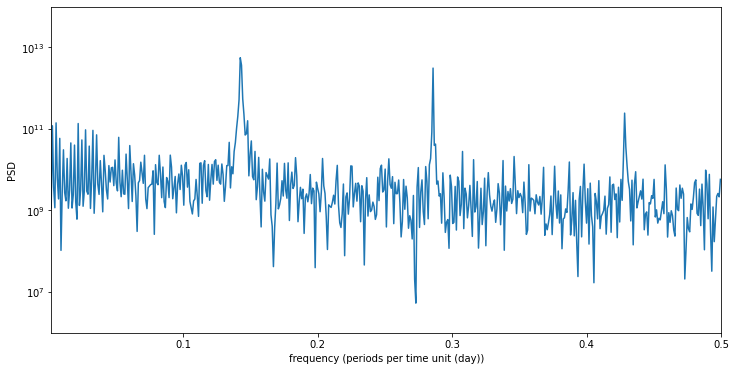

Strongest period length = 7.019230769230769


In [6]:
f, PSD = scipy.signal.periodogram(bart_t1.passenger)
plt.figure(figsize = (12,6))
plt.semilogy(f, PSD)
plt.xlabel('frequency (periods per time unit (day))')
plt.ylabel('PSD')
plt.xlim(0.002,0.5) #show frequencies within 1/4..1/200, periods of 2-365 days
plt.ylim(1e6,1e14) #show strength up to 1e-6 of the max

#filter outputs - periods shorter than 2 years (approx 100 weeks) 
#PSD = PSD[f>0.01]
#f = f[f>0.01] 
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) #report the length of the strongest period

#transformting the frequency into the period length, using 1=frequency (number of periods)*period length

<Figure size 576x576 with 0 Axes>

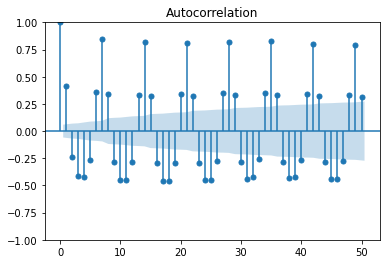

In [7]:
plt.figure(figsize = (8,8))
plot_acf(bart_t1['passenger'], lags = 50)
plt.show()
#plot autocorrelations for lags up to 50 days
#we see spikes around 7days (1 week), 14 days (2 weeks), ... highlighting an week period

<Figure size 576x576 with 0 Axes>

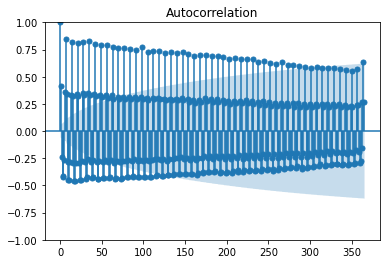

In [8]:
plt.figure(figsize = (8,8))
plot_acf(bart_t1['passenger'], lags = 365)
plt.show()
#plot autocorrelations for lags up to 365 days
#we see spikes around 7days (1 week), 14 days (2 weeks), ... highlighting an week period

### Task 3 Build a linear regression for trend+seasonality (using a weekly period with 7 dummy variables for each day of the week) to predict passenger count. Train on 2017 and 2018, test on 2019. Visualize the coefficients for each day of the week and analyze their significance

In [9]:
bart_t1['DOW'] = pd.to_datetime(bart_t1.date).dt.dayofweek #monday = 0, sunday = 6
bart_t1

,index,date,passenger,DOW
0,0,2017-01-01,122773,6
1,1,2017-01-02,139245,0
2,2,2017-01-03,366495,1
3,3,2017-01-04,388842,2
4,4,2017-01-05,407099,3
...,...,...,...,...
1090,1090,2019-12-27,229101,4
1091,1091,2019-12-28,136422,5
1092,1092,2019-12-29,83354,6
1093,1093,2019-12-30,257428,0


In [10]:
# train the model over the first 730 days (2 years)
X = pd.concat([pd.DataFrame(range(bart_t1.shape[0]),columns=['day']),pd.get_dummies(bart_t1['DOW'],drop_first=False)],axis=1)
#X = sm.add_constant(X) #we do not need an intercept as we have an individual constant for each day of the week (drop_first = False)
#alternatively we can add a constant but then exclude a dummy for Monday using drop_first = True - will do so below
lmbart_t1=sm.OLS(bart_t1.passenger[:730],X[:730]).fit()
print (lmbart_t1.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Mon, 06 Feb 2023   Prob (F-statistic):          3.58e-275
Time:                        22:17:32   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -22.1202      9.170     -2.412      0.0

(0.0, 500000.0)

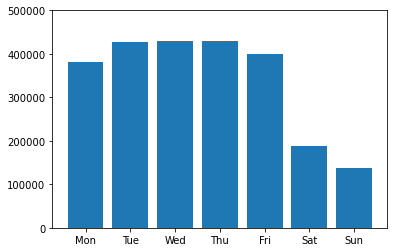

In [11]:
# visualize the effect of each day of week on taxi ridership
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lmbart_t1.params[1:].tolist())
plt.ylim([0,500000])

In [12]:
# train the model over the first 730 days (2 years)
X2 = pd.concat([pd.DataFrame(range(bart_t1.shape[0]),columns=['day']),pd.get_dummies(bart_t1['DOW'],drop_first=True)],axis=1)
X2 = sm.add_constant(X2) #use intercept instead of an exluded dummy for Monday; other dummies will be relative
lmbart_t3=sm.OLS(bart_t1.passenger[:730],X2[:730]).fit()
print (lmbart_t3.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Mon, 06 Feb 2023   Prob (F-statistic):          3.58e-275
Time:                        22:17:32   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.81e+05   6096.367     62.495      0.0

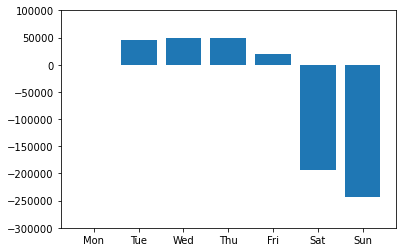

In [13]:
# visualize the effect of each day of week on taxi ridership; relatively Monday
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        [0] + lmbart_t3.params[2:].tolist())
plt.ylim([-300000,100000]);
plt.show()

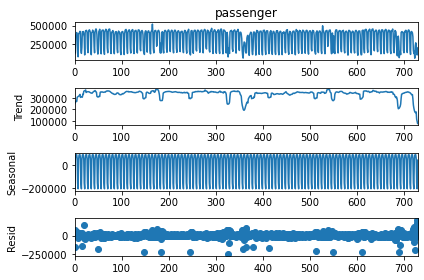

In [14]:
bart_t3 = bart_t1.iloc[:730]
dailyDecomp_t3 = seasonal_decompose(bart_t3['passenger'], model='additive', period = 7, extrapolate_trend='freq')
fig = dailyDecomp_t3.plot()

<BarContainer object of 7 artists>

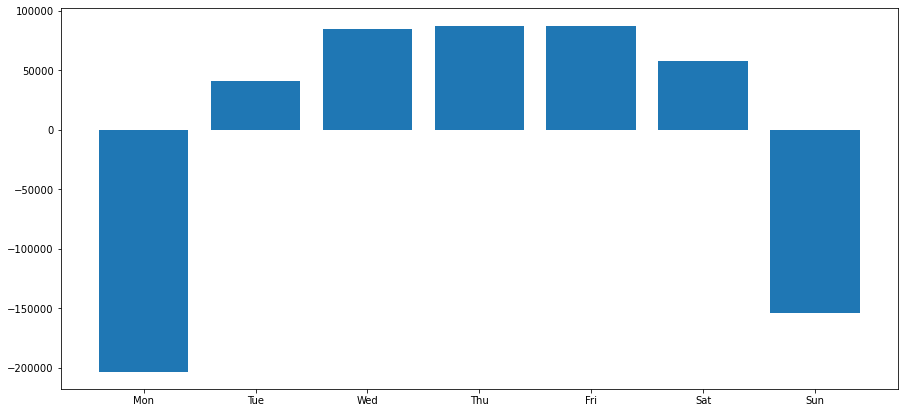

In [15]:
fig = plt.figure(figsize=(15, 7))
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        dailyDecomp_t3.seasonal[:7])

### Task 4, plot results and report insample and out-of-sample predictions. Report in-sample and out-of-sample $R^2$

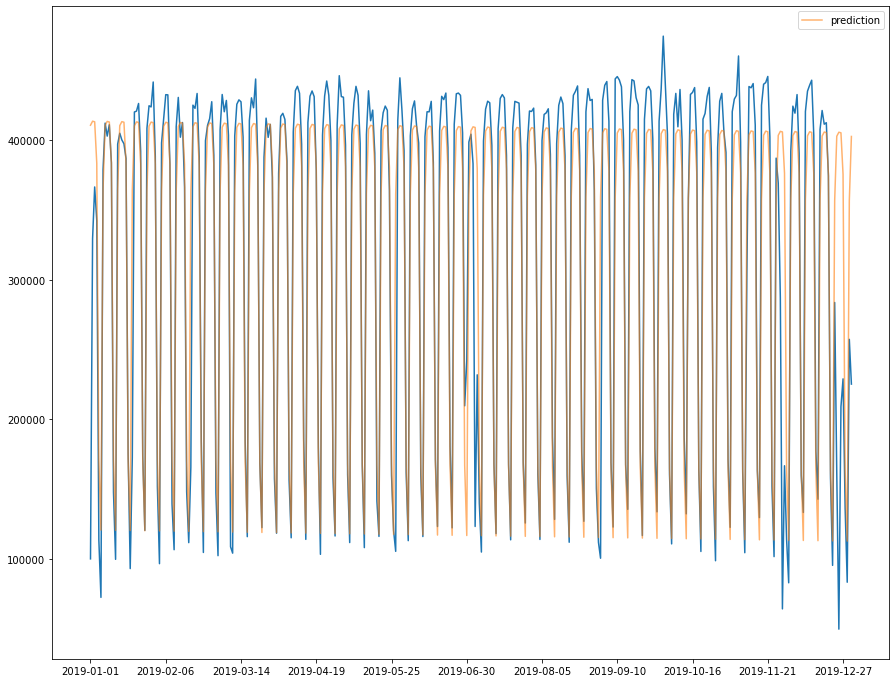

In [16]:
#use the model lmGreen trained over 2017-2018 to predict 2019 ridership
y = lmbart_t1.predict(X[730:])
#visualize the actual passenger vs the model prediction
fig = plt.figure(figsize = (15, 12))
plt.plot(bart_t1.date[730:],bart_t1.passenger[730:])
plt.plot(bart_t1.date[730:],y,label='prediction',alpha=0.6)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(36)) 
plt.legend()

In [17]:
#in-sample r2
y1=lmbart_t1.predict(X[0:730])
r2_score(bart_t1.passenger[0:730],y1[:730])

0.8324941917707158

In [18]:
#in-sample r2
print('in-sample R2:',lmbart_t1.rsquared)

in-sample R2: 0.8324941917707158


In [19]:
#out-of-sample  𝑅2 
r2_score(bart_t1.passenger[730:],y[:])

0.8203089387540557

### Task 5, Use the "multiplicative" seasonal_decompose with 7 day period to decompose the BART data and detect outliers based on the top and bottom 2.5% of the residuals

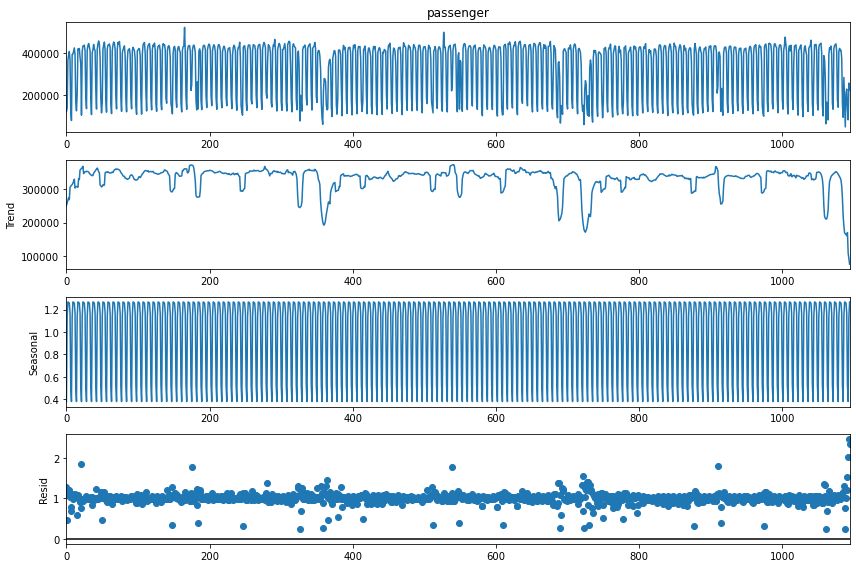

In [20]:
#use full data set
bart_t5 = bart_t1
dailyDecomp = seasonal_decompose(bart_t5.passenger, model='multicative', period = 7, extrapolate_trend='freq')
matplotlib.rcParams['figure.figsize'] = [12, 8]
fig = dailyDecomp.plot();

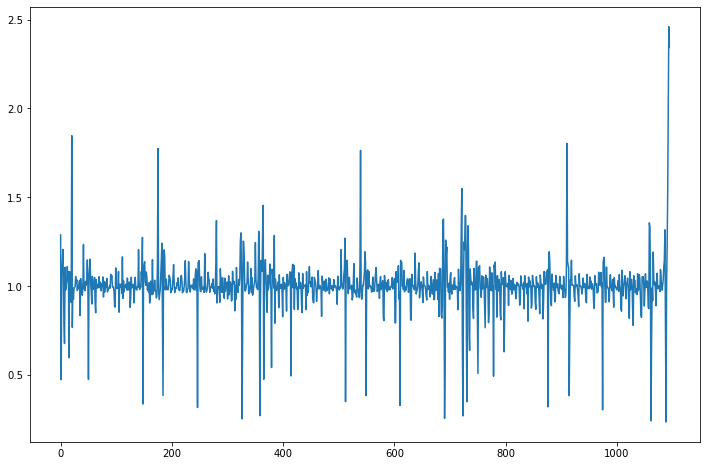

In [21]:
residualMult = np.array(dailyDecomp.resid)
resMult = dailyDecomp.resid
plt.show()
plt.plot(resMult);

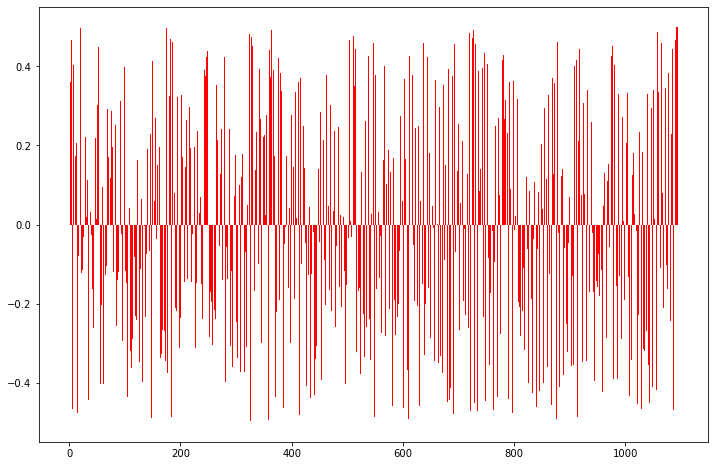

In [22]:
# based on percentile rank
outlierData = pd.DataFrame()
outlierData['Res'] = residualMult
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'], color='red')
plt.show()

In [23]:
# There is no certain definition of outliers, common methods include percentile, standard deviation, and IQR.
# In this case, we select 2.5% outliers.
bart_t5.date[outlierData['Percentile_rank']>0.475]

0       2017-01-01
20      2017-01-21
147     2017-05-28
175     2017-06-25
280     2017-10-08
324     2017-11-21
356     2017-12-23
363     2017-12-30
364     2017-12-31
384     2018-01-20
511     2018-05-27
539     2018-06-24
687     2018-11-19
688     2018-11-20
692     2018-11-24
720     2018-12-22
721     2018-12-23
727     2018-12-29
728     2018-12-30
732     2019-01-03
910     2019-06-30
1058    2019-11-25
1059    2019-11-26
1086    2019-12-23
1091    2019-12-28
1092    2019-12-29
1093    2019-12-30
1094    2019-12-31
Name: date, dtype: object

In [24]:
bart_t5.date[outlierData['Percentile_rank']<-0.475]

1       2017-01-02
15      2017-01-16
50      2017-02-20
148     2017-05-29
184     2017-07-04
246     2017-09-04
326     2017-11-23
358     2017-12-25
365     2018-01-01
379     2018-01-15
414     2018-02-19
512     2018-05-28
549     2018-07-04
610     2018-09-03
690     2018-11-22
691     2018-11-23
723     2018-12-25
730     2019-01-01
735     2019-01-06
750     2019-01-21
778     2019-02-18
797     2019-03-09
876     2019-05-27
914     2019-07-04
974     2019-09-02
1061    2019-11-28
1088    2019-12-25
Name: date, dtype: object

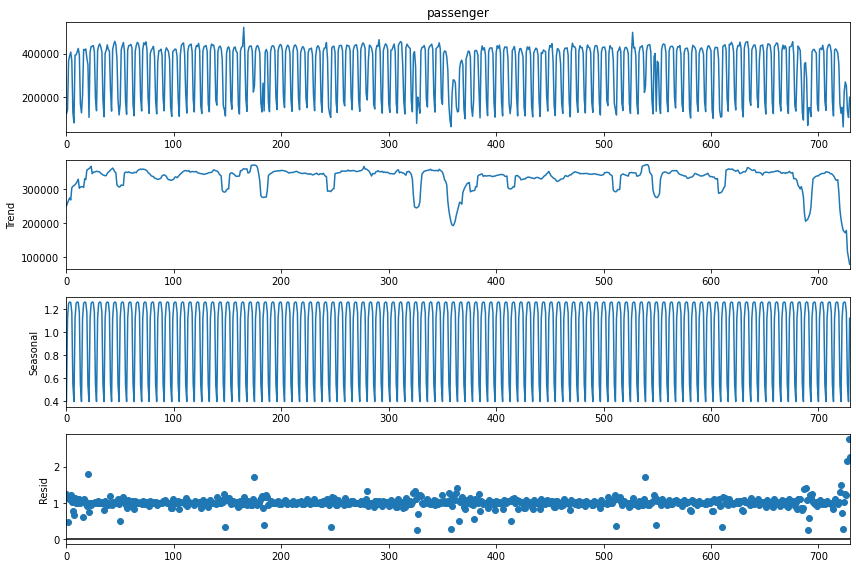

In [25]:
#use the 2017,2018 data set
bart_t6 = bart_t1.iloc[:730]
dailyDecomp1 = seasonal_decompose(bart_t6.passenger, model='multicative', period = 7, extrapolate_trend='freq')
matplotlib.rcParams['figure.figsize'] = [12, 8]
fig = dailyDecomp1.plot()

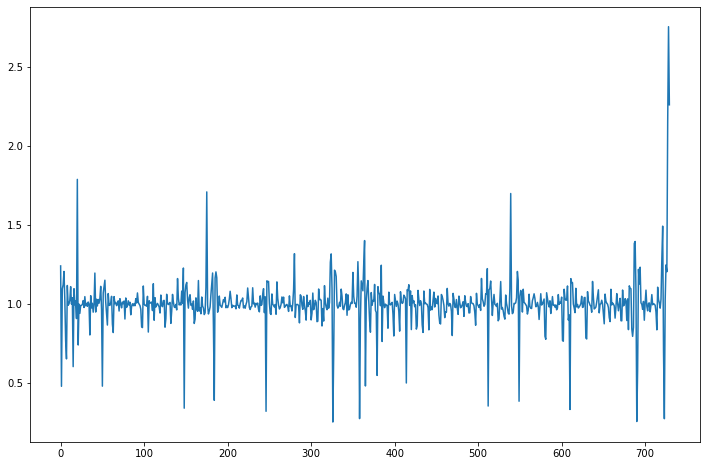

In [26]:
residualMult1 = np.array(dailyDecomp1.resid)
resMult1 = dailyDecomp1.resid
plt.show()
plt.plot(resMult1);

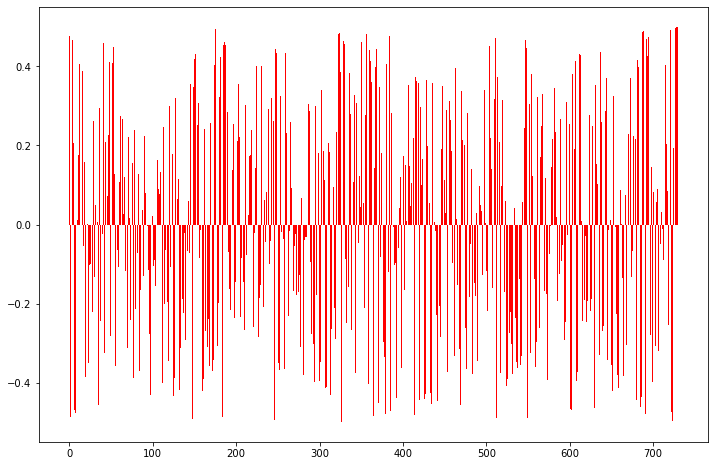

In [27]:
# based on percentile rank
outlierData1 = pd.DataFrame()
outlierData1['Res'] = residualMult1
outlierData1['Percentile_rank'] = outlierData1.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData1)), outlierData1['Percentile_rank'], color='red')
plt.show()

In [28]:
# There is no certain definition of outliers, common methods include percentile, standard deviation, and IQR.
# In this case, we select 2.5% outliers.
bart_t6.date[outlierData1['Percentile_rank']>0.475]

0      2017-01-01
20     2017-01-21
175    2017-06-25
280    2017-10-08
323    2017-11-20
324    2017-11-21
356    2017-12-23
363    2017-12-30
364    2017-12-31
384    2018-01-20
539    2018-06-24
687    2018-11-19
688    2018-11-20
720    2018-12-22
721    2018-12-23
725    2018-12-27
727    2018-12-29
728    2018-12-30
729    2018-12-31
Name: date, dtype: object

In [29]:
bart_t6.date[outlierData1['Percentile_rank']<-0.475]

1      2017-01-02
7      2017-01-08
15     2017-01-16
50     2017-02-20
148    2017-05-29
184    2017-07-04
246    2017-09-04
326    2017-11-23
358    2017-12-25
365    2018-01-01
379    2018-01-15
414    2018-02-19
512    2018-05-28
549    2018-07-04
610    2018-09-03
690    2018-11-22
691    2018-11-23
723    2018-12-25
Name: date, dtype: object